In [1]:
# class 20: accuracy: 81.7% after fine-tunning 83.8%

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models,regularizers,applications,callbacks,optimizers
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime 
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator # used for real-time data augmentation and preparing the dataset.

In [8]:
# Step 1: load data

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255, # sclae the pixel value from [0,255] to [0,1]
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True) 

# load training sets
train_generator = datagen.flow_from_directory( # used to load images from a directory
    '/Users/shawn/Desktop/auscar/train3', # Directory Path 
    target_size=(224,224), # image loaded will be resized to `128x128` pixels, fine-grained typically start from 128x128, 224x224
    batch_size=32, # load 32 images & labels each iteration(batch/step). network weights will be updated after each batch) 
    class_mode='categorical' # categorical for multi-class classification, one-hot coding will be used by default with 'categorical'
)
# load validation sets
validation_generator = datagen.flow_from_directory(
    '/Users/shawn/Desktop/auscar/test3',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
train_generator.class_indices # to show the labels 

Found 210 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


{'Ford Puma': 0, 'Hyundai Tucson': 1, 'Lexus NX': 2}

In [5]:
# step 2: build the model

base_model = applications.EfficientNetB0(
    input_shape= [224,224]  + [ 3 ],
    weights='imagenet',
    include_top=False)
base_model.trainable=False

# GlobalAveragePooling2D() and Flatten() both serve as transition layers
x = layers.GlobalAveragePooling2D()(base_model.output) # uncomment this for big model, can help aviod overfitting and reduece parameters
# x = layers.Flatten()(base_model.output) # uncomment this for smalll model, keep spatial information and require more data and computational resources 
# x = layers.Dropout(0.2)(x) # apply this layer to see if its help to avoid overfitting
x = layers.Dense(train_generator.num_classes,activation='softmax')(x)
model = models.Model(inputs=base_model.input,outputs=x)

## Uncomment this part for efficientNet only, fix the feature extraction part of the EfficientNet models
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [5]:
# step 3: compile the model 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# step 4: train the model  
early_stopping = callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=30,restore_best_weights=True)

# check time spent for training 
start_time = datetime.now() 

r = model.fit(
    train_generator, 
    validation_data=validation_generator,
    epochs=120, 
    callbacks=[early_stopping])
time_elapsed = datetime.now() - start_time

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Epoch 1/120


2023-10-03 20:12:49.068511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 1.0992 - accuracy: 0.3905

2023-10-03 20:14:07.908273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 104s 10s/step - loss: 1.0992 - accuracy: 0.3905 - val_loss: 1.1170 - val_accuracy: 0.3333
Epoch 2/120
7/7 [==============================] - 9s 1s/step - loss: 0.9829 - accuracy: 0.5190 - val_loss: 1.1206 - val_accuracy: 0.3333
Epoch 3/120
7/7 [==============================] - 7s 1s/step - loss: 0.8711 - accuracy: 0.6524 - val_loss: 1.1241 - val_accuracy: 0.3333
Epoch 4/120
7/7 [==============================] - 7s 1s/step - loss: 0.7623 - accuracy: 0.7429 - val_loss: 1.1149 - val_accuracy: 0.3333
Epoch 5/120
7/7 [==============================] - 7s 1s/step - loss: 0.7012 - accuracy: 0.7524 - val_loss: 1.1223 - val_accuracy: 0.3333
Epoch 6/120
7/7 [==============================] - 5s 749ms/step - loss: 0.6201 - accuracy: 0.8143 - val_loss: 1.1272 - val_accuracy: 0.3333
Epoch 7/120
7/7 [==============================] - 5s 752ms/step - loss: 0.5428 - accuracy: 0.8667 - val_loss: 1.1308 - val_accuracy: 0.3333
Epoch 8/120
7/7 [====================

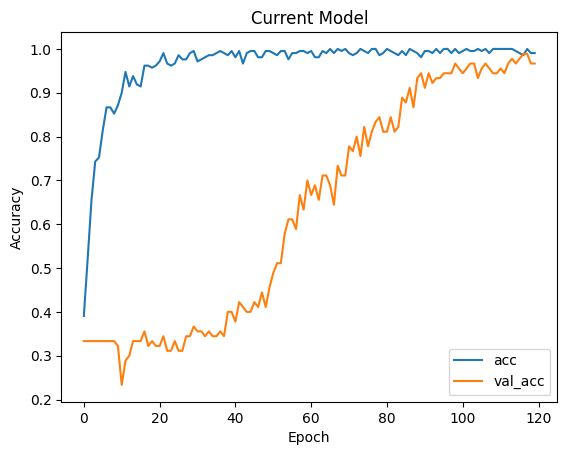

0.9888888597488403 116


In [6]:
# step 5: plot the model 

# check the best model metrics
# print("History keys:", r.history.keys())
r.history['val_accuracy'] 

# # plot the results
import matplotlib.pyplot as plt
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.title('Current Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

best_accucray=max(r.history['val_accuracy']) # get the val_accuracy of the best perform epoch 
index= r.history['val_accuracy'].index(best_accucray)# get the index of that best pefrom epoch  
print(best_accucray,index)

In [8]:
# step 6:  fine-tuning the model with fullly tainable layers
base_model.trainable=True
model.compile(optimizer=optimizers.legacy.Adam(1e-5), # use very small learning rate for fine-tuning,set 1e-5 or 1e-6
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=30,restore_best_weights=True)

start_time = datetime.now() 

r2 = model.fit(
    train_generator, 
    validation_data=validation_generator,
    epochs=100, 
    callbacks=[early_stopping])
time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Epoch 1/100


2023-10-03 21:27:09.581691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9952

2023-10-03 21:28:41.029887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 119s 12s/step - loss: 0.0176 - accuracy: 0.9952 - val_loss: 0.0646 - val_accuracy: 0.9778
Epoch 2/100
7/7 [==============================] - 15s 2s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1089 - val_accuracy: 0.9667
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 0.0225 - accuracy: 0.9905 - val_loss: 0.0951 - val_accuracy: 0.9889
Epoch 4/100
7/7 [==============================] - 15s 2s/step - loss: 0.0162 - accuracy: 0.9952 - val_loss: 0.0875 - val_accuracy: 0.9556
Epoch 5/100
7/7 [==============================] - 19s 2s/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0938 - val_accuracy: 0.9667
Epoch 6/100
7/7 [==============================] - 7s 992ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.1087 - val_accuracy: 0.9667
Epoch 7/100
7/7 [==============================] - 8s 1s/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1111 - val_accuracy: 0.9667
Epoch 8/100
7/7 [====================

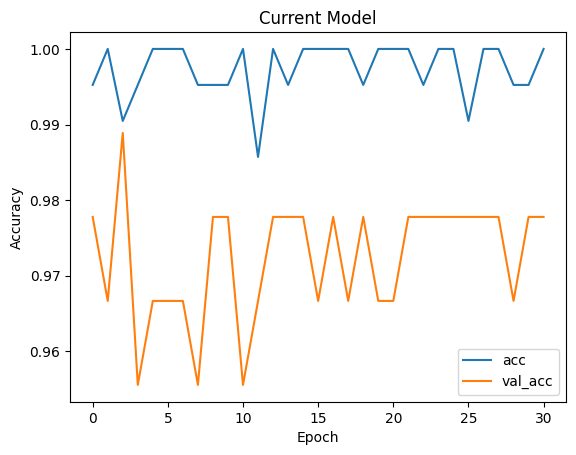

0.9888888597488403 2


/Users/shawn/.pyenv/versions/3.9.16/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# step 7: plot the model after fine-tuning 

# check the best model metrics
# print("History keys:", r.history.keys())
r2.history['val_accuracy'] 

# # plot the results
import matplotlib.pyplot as plt
plt.plot(r2.history['accuracy'],label='acc')
plt.plot(r2.history['val_accuracy'],label='val_acc')
plt.title('Current Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

best_accucray=max(r2.history['val_accuracy']) # get the val_accuracy of the best perform epoch 
index= r2.history['val_accuracy'].index(best_accucray)# get the index of that best pefrom epoch  
print(best_accucray,index)

model.save("model.h5")

In [6]:
model = tf.keras.models.load_model('model.h5')
# datagen = ImageDataGenerator() 
# train_generator = datagen.flow_from_directory('data')
from tensorflow.keras.preprocessing import image


def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)  # Apply the same preprocessing function used during training
    img_array /= 255.0  # Scale the image like you did during training
    img_array = np.expand_dims(img_array, axis=0)  # Make the image array 4D: (1, 224, 224, 3)
    return img_array
def predict_image(model, img_path):
    img_array = load_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0], axis=-1)
    return predicted_class
    
img_path = '/Users/shawn/Desktop/auscar/train/Jeep Compass/43.jpg'
predicted_class = predict_image(model, img_path)
print(f"Predicted class: {predicted_class}")

class_names = list(train_generator.class_indices.keys())
print(f"Predicted class name: {class_names[predicted_class]}")


2023-10-04 22:37:06.668773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 9s 9s/step
Predicted class: 1
Predicted class name: Hyundai Tucson
